In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
src = "/content/drive/MyDrive/kitti2012"
dst = "/content"
os.makedirs(dst, exist_ok=True)

!cp -r "$src" "$dst"

In [1]:
import os
import cv2
import json
import torch
import shutil
import logging
import numpy as np
import torchvision
import torch.optim as optim
import torchvision.ops as ops
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm
from PIL import Image
from collections import Counter
from torchsummary import summary
from typing import Dict, Any, Optional
from torchvision import transforms , models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class KITTI_Dataset(Dataset):
    def __init__(self, data_path, transform=None, mode='train'):
        self.data_path = data_path
        self.transform = transform
        self.mode = mode  # 'train', 'val', veya 'test'
        self.classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Cyclist', 'Tram', 'Misc', 'DontCare']
        self.class_map = {cls: idx for idx, cls in enumerate(self.classes)}
        self.data = []

        # KITTI görsel boyutları - normalizasyon için
        self.img_width = 1242
        self.img_height = 375
        self.max_depth = 80.0  # KITTI max derinlik

        image_dir = os.path.join(data_path, 'training', 'colored_0')
        label_dir = os.path.join(data_path, 'training', 'label_2')
        disp_dir = os.path.join(data_path, 'training', 'disp_noc')

        file_names = os.listdir(image_dir)
        for fname in file_names:
            if fname.endswith('.png'):
                scene_id = fname.split('_')[0]
                img_path = os.path.join(image_dir, fname)
                label_path = os.path.join(label_dir, f'{scene_id}.txt')
                disp_path = os.path.join(disp_dir, f'{scene_id}_10.png')
                if os.path.exists(label_path) and os.path.exists(disp_path):
                    self.data.append((img_path, label_path, disp_path))

    def __len__(self):
        return len(self.data)

    def convert_labels(self, label_file):
        """KITTI label_2 etiketlerini normalize ederek [category_num, x, y, w, h] formatına dönüştürür."""
        labels = []
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                category = parts[0]
                if category in self.class_map :
                    x1, y1, x2, y2 = map(float, parts[4:8])

                    # Merkez koordinat ve boyutları hesapla
                    x_center = (x1 + x2) / 2
                    y_center = (y1 + y2) / 2
                    width = x2 - x1
                    height = y2 - y1

                    # [0,1] aralığına normalize et
                    x_norm = x_center / self.img_width
                    y_norm = y_center / self.img_height
                    w_norm = width / self.img_width
                    h_norm = height / self.img_height

                    category_num = self.class_map[category]
                    labels.append([category_num, x_norm, y_norm, w_norm, h_norm])
        return labels

    def load_disparity(self, disp_path):
        """Disparite haritasını yükler."""
        disp_map = cv2.imread(disp_path, cv2.IMREAD_UNCHANGED) / 256.0
        return disp_map

    def calculate_depth(self, disp_map):
        """Disparite haritasından normalize edilmiş derinlik hesaplar."""
        baseline = 0.54
        focal_length = 721.5377
        depth = (baseline * focal_length) / (disp_map + 1e-6)
        depth = np.clip(depth, 0, self.max_depth)

        # [0,1] aralığına normalize et
        normalized_depth = depth / self.max_depth
        return normalized_depth

    def get_depth_at_box(self, depth_map, x, y, w, h):
        """Bounding box merkezindeki normalize edilmiş derinlik değerini döndürür."""
        # Normalize edilmiş koordinatları piksel koordinatlarına çevir
        x_pixel = int(x * self.img_width)
        y_pixel = int(y * self.img_height)

        # Sınır kontrolü
        x_pixel = np.clip(x_pixel, 0, self.img_width - 1)
        y_pixel = np.clip(y_pixel, 0, self.img_height - 1)

        if depth_map[y_pixel, x_pixel] == 0:
            return np.nan
        return depth_map[y_pixel, x_pixel]

    def get_disparity_at_box(self, disp_map, x, y, w, h):
        """Bounding box merkezindeki normalize edilmiş disparite değerini döndürür."""
        # Normalize edilmiş koordinatları piksel koordinatlarına çevir
        x_pixel = int(x * self.img_width)
        y_pixel = int(y * self.img_height)

        # Sınır kontrolü
        x_pixel = np.clip(x_pixel, 0, self.img_width - 1)
        y_pixel = np.clip(y_pixel, 0, self.img_height - 1)

        if disp_map[y_pixel, x_pixel] == 0:
            return np.nan

        # Disparite değerini de normalize et (max disparite ~300 civarı)
        max_disparity = 300.0
        normalized_disparity = disp_map[y_pixel, x_pixel] / max_disparity
        return np.clip(normalized_disparity, 0, 1)

    def __getitem__(self, idx):
        img_path, label_path, disp_path = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        labels = self.convert_labels(label_path)  # Artık normalize edilmiş koordinatlar
        disp_map = self.load_disparity(disp_path)

        if self.mode == 'train':
            # Eğitim: Normalize edilmiş disparite ile etiket döndür
            labels_with_disparity = []
            for label in labels:
                category_num, x, y, w, h = label
                disparity = self.get_disparity_at_box(disp_map, x, y, w, h)
                labels_with_disparity.append([category_num, x, y, w, h, disparity])
            output_labels = labels_with_disparity
        else:
            # Doğrulama/Test: Normalize edilmiş derinlik ile etiket döndür
            depth_map = self.calculate_depth(disp_map)
            labels_with_depth = []
            for label in labels:
                category_num, x, y, w, h = label
                depth = self.get_depth_at_box(depth_map, x, y, w, h)
                labels_with_depth.append([category_num, x, y, w, h, depth])
            output_labels = labels_with_depth

        if self.transform:
            image = self.transform(image)

        return image, output_labels
def kitti_collate_fn(batch):
    images = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    images = torch.stack(images, dim=0)  # [B, C, H, W]
    return images, labels

# Transform tanımla
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [3]:
data_path = "/content/kitti2012" #colab
#data_path = "C:/Users/Mehmet/Desktop/kitti2012" #lcoal
test_path = data_path+"/testing"

image_size=300
batch_size=2

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_val_dataset = KITTI_Dataset(data_path=data_path, transform=transform, mode='train')
train_size = int(0.8 * len(train_val_dataset))  # ~155 sahne
val_size = len(train_val_dataset) - train_size  # ~39 sahne
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
val_dataset.dataset.mode = 'val'
#test_dataset  = KITTI_Dataset(test_path,transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0,collate_fn=kitti_collate_fn)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,pin_memory=True, num_workers=0,collate_fn=kitti_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0,collate_fn=kitti_collate_fn)

In [4]:
print(f"Veri seti boyutu: {len(train_dataset)} örnek")
cls_labels=[]
depth_maps = []
bboxes = []
for i in range(len(train_dataset)):
  for j in range(len(train_dataset[i][1])):
    cls_labels.append(train_dataset[i][1][j][0])
    depth_maps.append(train_dataset[i][1][j][5])
    bboxes.append(train_dataset[i][1][j][1:4])

Veri seti boyutu: 310 örnek


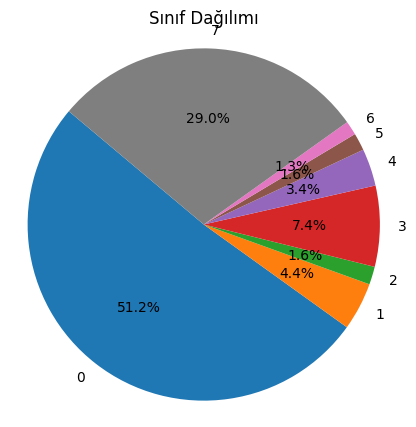

In [5]:
cls_distribution = Counter(cls_labels)
sorted_cls_distribution = sorted(cls_distribution.items(), key=lambda x: x[0])

class_weights = torch.tensor([i[1]for i in sorted_cls_distribution],
                             dtype=torch.float32).to(device)
labels, values = zip(*sorted_cls_distribution)

plt.figure(figsize=(5, 5))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sınıf Dağılımı')
plt.axis('equal')
plt.show()


In [6]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = (kernel_size - 1) // 2
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        x_out = self.conv1(x_cat)
        attention_map = self.sigmoid(x_out)
        return x * attention_map

class EncoderBackBone(nn.Module):
    def __init__(self,İsPretreained=True):
        super(EncoderBackBone,self).__init__()
        efficient = models.efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.features = efficient.features
        self.SAttention = SpatialAttention()

    def forward(self, x):         # B,C,H,W

        outs = []

        # Her iki frame için özellikler
        for i, block in enumerate(self.features):
            x = block(x)
            if i > 2:  # C3'ten sonrası için Spatial Attention
                x = x * self.SAttention(x)
            if i in [3,5,7]:
                out = F.interpolate(x, size=256, mode='bilinear', align_corners=False)
                outs.append(out)
        return outs

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size,
                                 stride, padding, groups=in_channels, bias=False)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.swish = nn.SiLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.swish(x)

class BiFPNBlock(nn.Module):
    def __init__(self, channels, epsilon=1e-4):
        super(BiFPNBlock, self).__init__()
        self.epsilon = epsilon
        self.channels = channels

        # Convolution layers for each level
        self.conv_p3 = DepthwiseSeparableConv(channels, channels)
        self.conv_p4 = DepthwiseSeparableConv(channels, channels)
        self.conv_p5 = DepthwiseSeparableConv(channels, channels)
        self.conv_p6 = DepthwiseSeparableConv(channels, channels)
        self.conv_p7 = DepthwiseSeparableConv(channels, channels)

        # Weight parameters for feature fusion
        self.w1 = nn.Parameter(torch.ones(2))
        self.w2 = nn.Parameter(torch.ones(2))
        self.w3 = nn.Parameter(torch.ones(2))
        self.w4 = nn.Parameter(torch.ones(2))
        self.w5 = nn.Parameter(torch.ones(3))
        self.w6 = nn.Parameter(torch.ones(3))
        self.w7 = nn.Parameter(torch.ones(3))
        self.w8 = nn.Parameter(torch.ones(2))

    def forward(self, inputs):
        P3, P4, P5, P6, P7 = inputs

        # Bottom-up pathway
        w1 = F.relu(self.w1)
        P6_td = (w1[0] * P6 + w1[1] * self.up_sampling(P7, P6.shape[-2:])) / (w1.sum() + self.epsilon)
        P6_td = self.conv_p6(P6_td)

        w2 = F.relu(self.w2)
        P5_td = (w2[0] * P5 + w2[1] * self.up_sampling(P6_td, P5.shape[-2:])) / (w2.sum() + self.epsilon)
        P5_td = self.conv_p5(P5_td)

        w3 = F.relu(self.w3)
        P4_td = (w3[0] * P4 + w3[1] * self.up_sampling(P5_td, P4.shape[-2:])) / (w3.sum() + self.epsilon)
        P4_td = self.conv_p4(P4_td)

        # Top-down pathway
        w4 = F.relu(self.w4)
        P3_out = (w4[0] * P3 + w4[1] * self.up_sampling(P4_td, P3.shape[-2:])) / (w4.sum() + self.epsilon)
        P3_out = self.conv_p3(P3_out)

        w5 = F.relu(self.w5)
        P4_out = (w5[0] * P4 + w5[1] * P4_td + w5[2] * self.down_sampling(P3_out, P4.shape[-2:])) / (w5.sum() + self.epsilon)
        P4_out = self.conv_p4(P4_out)

        w6 = F.relu(self.w6)
        P5_out = (w6[0] * P5 + w6[1] * P5_td + w6[2] * self.down_sampling(P4_out, P5.shape[-2:])) / (w6.sum() + self.epsilon)
        P5_out = self.conv_p5(P5_out)

        w7 = F.relu(self.w7)
        P6_out = (w7[0] * P6 + w7[1] * P6_td + w7[2] * self.down_sampling(P5_out, P6.shape[-2:])) / (w7.sum() + self.epsilon)
        P6_out = self.conv_p6(P6_out)

        w8 = F.relu(self.w8)
        P7_out = (w8[0] * P7 + w8[1] * self.down_sampling(P6_out, P7.shape[-2:])) / (w8.sum() + self.epsilon)
        P7_out = self.conv_p7(P7_out)

        return [P3_out, P4_out, P5_out, P6_out, P7_out]

    def up_sampling(self, x, target_size):
        return F.interpolate(x, size=target_size, mode='nearest')

    def down_sampling(self, x, target_size):
        if x.shape[-2:] == target_size:
            return x
        stride = x.shape[-1] // target_size[-1]
        kernel_size = stride
        return F.max_pool2d(x, kernel_size=kernel_size, stride=stride)

class BiFPN(nn.Module):
    def __init__(self, in_channels_list, out_channels=256, num_blocks=3):
        super(BiFPN, self).__init__()
        self.out_channels = out_channels
        self.num_blocks = num_blocks

        # Input projection layers
        self.input_convs = nn.ModuleList([
            nn.Conv2d(in_ch, out_channels, 1, bias=False)
            for in_ch in in_channels_list
        ])

        # Additional P6 and P7 layers
        self.p6_conv = nn.Conv2d(in_channels_list[-1], out_channels, 3, stride=2, padding=1)
        self.p7_conv = nn.Conv2d(out_channels, out_channels, 3, stride=2, padding=1)

        # BiFPN blocks
        self.bifpn_blocks = nn.ModuleList([
            BiFPNBlock(out_channels) for _ in range(num_blocks)
        ])

    def forward(self, inputs):
        # Project input features
        features = []
        for i, feat in enumerate(inputs):
            features.append(self.input_convs[i](feat))

        # Create P6 and P7
        P6 = self.p6_conv(inputs[-1])
        P7 = self.p7_conv(P6)

        # Initial feature list
        pyramid_features = features + [P6, P7]

        # Apply BiFPN blocks
        for block in self.bifpn_blocks:
            pyramid_features = block(pyramid_features)

        return pyramid_features

class NNConv3UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return x

class FusionBlock(nn.Module):
    def __init__(self, fusion_type='add'):
        super().__init__()
        self.fusion_type = fusion_type

    def forward(self, high_level, low_level):
        if self.fusion_type == 'add':
            return high_level + low_level
        elif self.fusion_type == 'concat':
            return torch.cat([high_level, low_level], dim=1)

class PredictionDecoder(nn.Module):
    def __init__(self, in_channels, out_channels=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels//2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels//2, out_channels, kernel_size=3, padding=1)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        return x

class RTMonoDepthDecoder(nn.Module):
    def __init__(self, encoder_channels=[48, 136, 384], decoder_channels=[256, 128, 64, 32]):
        super().__init__()

        # Upsampling blocks
        self.upconv2 = NNConv3UpBlock(encoder_channels[2], decoder_channels[0])  # F3 -> D2
        self.upconv1 = NNConv3UpBlock(decoder_channels[0], decoder_channels[1])  # After fusion -> D1
        self.upconv0 = NNConv3UpBlock(decoder_channels[1], decoder_channels[2])  # After fusion -> D0

        # Projection layers to match dimensions for fusion
        self.proj2 = nn.Conv2d(encoder_channels[1], decoder_channels[0], 1)  # F2 -> D2 channels
        self.proj1 = nn.Conv2d(encoder_channels[0], decoder_channels[1], 1)  # F1 -> D1 channels

        # Fusion blocks
        self.fusion1 = FusionBlock('add')
        self.fusion0 = FusionBlock('concat')

        # Prediction decoders at each scale
        self.decoder2 = PredictionDecoder(decoder_channels[0])
        self.decoder1 = PredictionDecoder(decoder_channels[1])
        # After concat: up1_resized (128) + f1_proj (128) = 256 channels
        self.decoder0 = PredictionDecoder(decoder_channels[1] + decoder_channels[1])

    def forward(self, features, inference_mode=False):
        f1, f2, f3 = features  # [low_res -> high_res]
        depth_maps = {}

        # Level 2: Start from highest level feature
        up2 = self.upconv2(f3)
        if not inference_mode:
            depth_maps['depth_2'] = self.decoder2(up2)

        # Level 1: Project F2 to match up2 channels and fuse
        f2_proj = self.proj2(f2)
        # Resize up2 to match f2 spatial dimensions
        up2_resized = F.interpolate(up2, size=f2_proj.shape[-2:], mode='bilinear', align_corners=False)
        fused1 = self.fusion1(up2_resized, f2_proj)
        up1 = self.upconv1(fused1)
        if not inference_mode:
            depth_maps['depth_1'] = self.decoder1(up1)

        # Level 0: Project F1 to match up1 channels and fuse
        f1_proj = self.proj1(f1)
        # Resize up1 to match f1 spatial dimensions
        up1_resized = F.interpolate(up1, size=f1_proj.shape[-2:], mode='bilinear', align_corners=False)
        fused0 = self.fusion0(up1_resized, f1_proj)
        depth_maps['depth_0'] = self.decoder0(fused0)

        return depth_maps
class DepthHead(nn.Module):
    def __init__(self, in_channels=256):
        super(DepthHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )
        self.weights = nn.Parameter(torch.ones(5))

    def weighted_fusion(self, features, weights, target_size):
        weights = F.softmax(weights, dim=0)
        fused = None
        for feat, weight in zip(features, weights):
            if feat.shape[2:] != target_size:
                feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
            if fused is None:
                fused = weight * feat
            else:
                fused += weight * feat
        return fused

    def forward(self, features):
        processed = [self.conv(feat) for feat in features]
        target_size = processed[0].shape[2:]
        return self.weighted_fusion(processed, self.weights, target_size)

class ClassificationHead(nn.Module):
    def __init__(self, in_channels=256, num_classes=10):
        super(ClassificationHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, 1)
        )
        self.weights = nn.Parameter(torch.ones(5))

    def weighted_fusion(self, features, weights, target_size):
        weights = F.softmax(weights, dim=0)
        fused = None
        for feat, weight in zip(features, weights):
            if feat.shape[2:] != target_size:
                feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
            if fused is None:
                fused = weight * feat
            else:
                fused += weight * feat
        return fused

    def forward(self, features):
        processed = [self.conv(feat) for feat in features]
        target_size = processed[0].shape[2:]
        return self.weighted_fusion(processed, self.weights, target_size)

class RegressionHead(nn.Module):
    def __init__(self, in_channels=256):
        super(RegressionHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 4, 1)
        )
        self.weights = nn.Parameter(torch.ones(5))

    def weighted_fusion(self, features, weights, target_size):
        weights = F.softmax(weights, dim=0)
        fused = None
        for feat, weight in zip(features, weights):
            if feat.shape[2:] != target_size:
                feat = F.interpolate(feat, size=target_size, mode='bilinear', align_corners=False)
            if fused is None:
                fused = weight * feat
            else:
                fused += weight * feat
        return fused

    def forward(self, features):
        processed = [self.conv(feat) for feat in features]
        target_size = processed[0].shape[2:]
        return self.weighted_fusion(processed, self.weights, target_size)

class MultiTaskHeads(nn.Module):
    def __init__(self, num_classes=10, in_channels=256):
        super(MultiTaskHeads, self).__init__()
        self.depth_head = DepthHead(in_channels)
        self.cls_head = ClassificationHead(in_channels, num_classes)
        self.reg_head = RegressionHead(in_channels)

    def forward(self, features):
        depth = self.depth_head(features)
        cls = self.cls_head(features)
        reg = self.reg_head(features)
        return {
            'depth': depth,
            'classification': cls,
            'regression': reg
        }

class DetectionPostProcessor(nn.Module):
    """Post-process detection outputs to final format [cls, x, y, w, h, depth]"""
    def __init__(self, num_classes=80, confidence_threshold=0.5, max_detections=100):
        super(DetectionPostProcessor, self).__init__()
        self.num_classes = num_classes
        self.confidence_threshold = confidence_threshold
        self.max_detections = max_detections

    def forward(self, classification, regression, depth, return_raw=False):
        """
        Args:
            classification: [B, num_classes, H, W] - class probabilities
            regression: [B, 4, H, W] - bbox coordinates (x, y, w, h)
            depth: [B, 1, H, W] - depth values
            return_raw: if True, return raw outputs without post-processing

        Returns:
            if return_raw=True:
                raw_outputs: [B, 6+num_classes, H, W] - concatenated raw outputs
            else:
                detections: [B, max_detections, 6] - [cls_id, x, y, w, h, depth]
                scores: [B, max_detections] - confidence scores
        """
        batch_size, _, height, width = classification.shape

        if return_raw:
            # Return raw concatenated outputs for training
            # Format: [cls_probs(num_classes), x, y, w, h, depth]
            raw_outputs = torch.cat([
                classification,  # [B, num_classes, H, W]
                regression,      # [B, 4, H, W]
                depth           # [B, 1, H, W]
            ], dim=1)  # [B, num_classes+5, H, W]
            return raw_outputs

        # Post-process for inference
        device = classification.device

        # Apply softmax to classification
        cls_probs = F.softmax(classification, dim=1)  # [B, num_classes, H, W]

        # Get max class probabilities and indices
        max_scores, class_ids = torch.max(cls_probs, dim=1, keepdim=True)  # [B, 1, H, W]

        # Filter by confidence threshold
        valid_mask = (max_scores > self.confidence_threshold).squeeze(1)  # [B, H, W]

        batch_detections = []
        batch_scores = []

        for b in range(batch_size):
            # Get valid positions for this batch
            valid_positions = torch.nonzero(valid_mask[b], as_tuple=False)  # [N, 2] (y, x coordinates)

            if len(valid_positions) == 0:
                # No valid detections
                detections = torch.zeros((self.max_detections, 6), device=device)
                scores = torch.zeros(self.max_detections, device=device)
            else:
                # Extract values at valid positions
                y_coords, x_coords = valid_positions[:, 0], valid_positions[:, 1]

                # Get predictions at valid positions
                batch_class_ids = class_ids[b, 0, y_coords, x_coords]  # [N]
                batch_scores_raw = max_scores[b, 0, y_coords, x_coords]  # [N]
                batch_regression = regression[b, :, y_coords, x_coords].t()  # [N, 4]
                batch_depth = depth[b, 0, y_coords, x_coords]  # [N]

                # Convert relative coordinates to absolute (if needed)
                # Assuming regression outputs are already in proper format
                bbox_x = batch_regression[:, 0]
                bbox_y = batch_regression[:, 1]
                bbox_w = batch_regression[:, 2]
                bbox_h = batch_regression[:, 3]

                # Stack all predictions
                batch_detections_raw = torch.stack([
                    batch_class_ids.float(),  # class id
                    bbox_x,                   # x
                    bbox_y,                   # y
                    bbox_w,                   # w
                    bbox_h,                   # h
                    batch_depth               # depth
                ], dim=1)  # [N, 6]

                # Sort by confidence and take top max_detections
                sorted_indices = torch.argsort(batch_scores_raw, descending=True)
                sorted_indices = sorted_indices[:self.max_detections]

                # Pad if necessary
                num_detections = min(len(sorted_indices), self.max_detections)
                detections = torch.zeros((self.max_detections, 6), device=device)
                scores = torch.zeros(self.max_detections, device=device)

                if num_detections > 0:
                    detections[:num_detections] = batch_detections_raw[sorted_indices[:num_detections]]
                    scores[:num_detections] = batch_scores_raw[sorted_indices[:num_detections]]

            batch_detections.append(detections)
            batch_scores.append(scores)

        # Stack batch results
        final_detections = torch.stack(batch_detections, dim=0)  # [B, max_detections, 6]
        final_scores = torch.stack(batch_scores, dim=0)          # [B, max_detections]

        return final_detections, final_scores

class CompleteMultiTaskModel(nn.Module):
    def __init__(self,İsPretreained=True, num_classes=10, bifpn_channels=256, bifpn_blocks=3, confidence_threshold=0.5, max_detections=100):
        super(CompleteMultiTaskModel, self).__init__()
        self.encoder = EncoderBackBone(İsPretreained)
        in_channels_list = [48, 136, 384]  # EfficientNet-B3 kanal boyutları
        self.bifpn = BiFPN(in_channels_list, bifpn_channels, bifpn_blocks)
        self.depth_decoder = RTMonoDepthDecoder()
        self.detection_heads = MultiTaskHeads(num_classes, bifpn_channels)
        self.post_processor = DetectionPostProcessor(num_classes, confidence_threshold, max_detections)

    def forward(self, images, K=None, inference_mode=False, mode="train"):
        # Backbone features
        backbone_features = self.encoder(images)  # outs

        # Depth estimation
        depth_maps = self.depth_decoder(backbone_features, inference_mode)

        # Object detection via BiFPN
        bifpn_features = self.bifpn(backbone_features)  # [P3, P4, P5, P6, P7]
        detection_outputs = self.detection_heads(bifpn_features)

        if mode == "train":
            # For training: return raw outputs
            # Raw format: [cls_probs(num_classes), x, y, w, h, depth]
            raw_detections = self.post_processor(
                detection_outputs['classification'],
                detection_outputs['regression'],
                detection_outputs['depth']
            )

            outputs = {
                'depth_maps': depth_maps,  # Multi-scale depth maps for depth loss
                'raw_detections': raw_detections,  # [B, num_classes+5, H, W] for detection loss
                'detection_depth': detection_outputs['depth'],  # Single scale detection depth
                'classification': detection_outputs['classification'],  # For individual losses if needed
                'regression': detection_outputs['regression']  # For individual losses if needed
            }
        else:
            # For inference: return post-processed detections
            final_detections, scores = self.post_processor(
                detection_outputs['classification'],
                detection_outputs['regression'],
                detection_outputs['depth']
            )

            outputs = {
                'depth_maps': depth_maps,
                'detections': final_detections,  # [B, max_detections, 6] - [cls, x, y, w, h, depth]
                'scores': scores,  # [B, max_detections] - confidence scores
                'detection_depth': detection_outputs['depth']
            }

        return outputs

In [7]:
class MultiTaskLoss(nn.Module):
    """Multi-task loss with automatic weighting"""
    def __init__(self, num_tasks=4, loss_weights=None):
        super(MultiTaskLoss, self).__init__()
        self.num_tasks = num_tasks

        # Loss functions for each task
        self.classification_loss = nn.CrossEntropyLoss(weight=class_weights)
        self.regression_loss = nn.MSELoss()
        self.depth_loss = nn.L1Loss()
        self.depth_map_loss = nn.L1Loss()

        # Learnable loss weights (uncertainty weighting)
        if loss_weights is None:
            self.log_vars = nn.Parameter(torch.zeros(num_tasks))
        else:
            self.register_buffer('loss_weights', torch.tensor(loss_weights))
            self.log_vars = None

    def forward(self, outputs, targets):
        """
        outputs: model outputs dict with spatial outputs
        targets: ground truth dict with object-level targets from KITTI
        """
        losses = {}

        # Get batch size
        batch_size = targets['classification'].shape[0]

        # Classification loss - need to handle spatial vs object-level mismatch
        if 'classification' in outputs and 'classification' in targets:
            # outputs['classification']: [B, 8, 256, 256] - spatial classification map
            # targets['classification']: [B, num_objects] - object class indices

            # For now, use a simplified approach - average pool the spatial output
            cls_output = outputs['classification'].mean(dim=[2, 3])  # [B, 8]

            # Create target for each batch - use first object's class (simplified)
            cls_targets = []
            for b in range(batch_size):
                if len(targets['classification'][b]) > 0:
                    # Use first valid object's class
                    valid_objects = targets['classification'][b][targets['classification'][b] >= 0]
                    if len(valid_objects) > 0:
                        cls_targets.append(valid_objects[0])
                    else:
                        cls_targets.append(torch.tensor(0))  # Default class
                else:
                    cls_targets.append(torch.tensor(0))  # Default class

            cls_targets = torch.stack(cls_targets).to(cls_output.device)
            cls_loss = self.classification_loss(cls_output, cls_targets.long())
            losses['classification'] = cls_loss

        # Regression loss - similar handling needed
        if 'regression' in outputs and 'regression' in targets:
            # outputs['regression']: [B, 4, 256, 256] - spatial regression map
            # targets['regression']: [B, num_objects, 4] - object bbox coordinates

            reg_output = outputs['regression'].mean(dim=[2, 3])  # [B, 4]

            # Use first object's bbox (simplified)
            reg_targets = []
            for b in range(batch_size):
                if len(targets['regression'][b]) > 0:
                    reg_targets.append(targets['regression'][b][0])  # First object
                else:
                    reg_targets.append(torch.zeros(4))  # Default bbox

            reg_targets = torch.stack(reg_targets).to(reg_output.device)
            reg_loss = self.regression_loss(reg_output, reg_targets.float())
            losses['regression'] = reg_loss

        # Detection depth loss
        if 'detection_depth' in outputs and 'depth' in targets:
            # outputs['detection_depth']: [B, 1, 256, 256] - spatial depth map
            # targets['depth']: [B, num_objects, 1] - object depth values

            depth_output = outputs['detection_depth'].mean(dim=[2, 3])  # [B, 1]

            # Use first object's depth (simplified)
            depth_targets = []
            for b in range(batch_size):
                if len(targets['depth'][b]) > 0:
                    # Filter out NaN values
                    valid_depths = targets['depth'][b][~torch.isnan(targets['depth'][b])]
                    if len(valid_depths) > 0:
                        depth_targets.append(valid_depths[0])
                    else:
                        depth_targets.append(torch.tensor([0.0]))
                else:
                    depth_targets.append(torch.tensor([0.0]))

            depth_targets = torch.stack(depth_targets).to(depth_output.device)

            # Only calculate loss for valid (non-NaN) targets
            valid_mask = ~torch.isnan(depth_targets)
            if valid_mask.any():
                depth_loss = self.depth_loss(depth_output[valid_mask], depth_targets[valid_mask].float())
            else:
                depth_loss = torch.tensor(0.0, device=depth_output.device)

            losses['detection_depth'] = depth_loss

        # Depth map loss (this is spatial to spatial, so direct comparison)
        if 'depth_maps' in outputs and 'depth_map' in targets:
            depth_map = outputs['depth_maps']['depth_2']  # [B, 1, 512, 512]
            target_depth_map = targets['depth_map']       # [B, 1, 512, 512]

            depth_map_loss = self.depth_map_loss(depth_map, target_depth_map)
            losses['depth_map'] = depth_map_loss

        # Combine losses
        if self.log_vars is not None:
            # Uncertainty weighting
            total_loss = 0
            for i, (task, loss) in enumerate(losses.items()):
                weight = torch.exp(-self.log_vars[i])
                total_loss += weight * loss + self.log_vars[i]
        else:
            # Fixed weighting
            total_loss = sum(self.loss_weights[i] * loss for i, loss in enumerate(losses.values()))

        losses['total'] = total_loss
        return losses

def train_model(model, train_loader, val_loader, num_epochs=100,
                learning_rate=1e-4, device='cuda', save_path='model_checkpoint.pth',
                log_interval=10, val_interval=5):
    """
    Multi-task model training function

    Args:
        model: The multi-task model
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate
        device: Device to train on
        save_path: Path to save best model
        log_interval: Logging interval
        val_interval: Validation interval
    """

    # Setup logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)

    # Move model to device
    model = model.to(device)

    # Loss function and optimizer
    criterion = MultiTaskLoss(num_tasks=4).to(device)
    optimizer = optim.AdamW(list(model.parameters()) + list(criterion.parameters()),
                           lr=learning_rate, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.5, patience=10, verbose=True)

    # Training history
    train_history = {'total': [], 'classification': [], 'regression': [],
                    'detection_depth': [], 'depth_map': []}
    val_history = {'total': [], 'classification': [], 'regression': [],
                  'detection_depth': [], 'depth_map': []}

    best_val_loss = float('inf')

    logger.info(f"Starting training for {num_epochs} epochs")

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = {'total': 0, 'classification': 0, 'regression': 0,
                       'detection_depth': 0, 'depth_map': 0}
        train_samples = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for batch_idx, (images, targets) in enumerate(pbar):
            # Move data to device
            images = images.to(device)

            # Prepare targets for KITTI format
            # targets comes from kitti_collate_fn as a list of lists
            # Each inner list contains [category_num, x, y, w, h, disparity/depth] for each object

            target_dict = {}
            batch_size = len(targets)

            # Find max number of objects in the batch for padding
            max_objects = max(len(target_list) for target_list in targets) if targets else 1

            # Initialize tensors
            cls_labels = torch.full((batch_size, max_objects), -1, dtype=torch.long)  # -1 for padding
            bbox_labels = torch.zeros((batch_size, max_objects, 4), dtype=torch.float32)
            depth_labels = torch.full((batch_size, max_objects, 1), float('nan'), dtype=torch.float32)

            # Fill the tensors
            for b, target_list in enumerate(targets):
                for obj_idx, obj_data in enumerate(target_list):
                    if obj_idx < max_objects:
                        category_num, x, y, w, h, depth_or_disp = obj_data
                        cls_labels[b, obj_idx] = int(category_num)
                        bbox_labels[b, obj_idx] = torch.tensor([x, y, w, h], dtype=torch.float32)

                        # Handle NaN values in depth/disparity
                        if not np.isnan(depth_or_disp):
                            depth_labels[b, obj_idx, 0] = depth_or_disp

            # Move to device
            target_dict['classification'] = cls_labels.to(device)
            target_dict['regression'] = bbox_labels.to(device)
            target_dict['depth'] = depth_labels.to(device)

            # Create dummy depth map for now (you should provide real depth maps)
            target_dict['depth_map'] = torch.zeros(batch_size, 1, 512, 512).to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(images, mode="train")

            # Calculate losses
            losses = criterion(outputs, target_dict)

            # Backward pass
            losses['total'].backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Update running losses
            batch_size = images.size(0)
            train_samples += batch_size

            for key, loss in losses.items():
                train_losses[key] += loss.item() * batch_size

            # Update progress bar
            pbar.set_postfix({
                'Total Loss': f"{losses['total'].item():.4f}",
                'Cls': f"{losses.get('classification', torch.tensor(0)).item():.4f}",
                'Reg': f"{losses.get('regression', torch.tensor(0)).item():.4f}",
                'Depth': f"{losses.get('detection_depth', torch.tensor(0)).item():.4f}",
                'DMap': f"{losses.get('depth_map', torch.tensor(0)).item():.4f}"
            })

        # Calculate average training losses
        for key in train_losses:
            train_losses[key] /= train_samples
            train_history[key].append(train_losses[key])

        # Validation phase
        if (epoch + 1) % val_interval == 0:
            model.eval()
            val_losses = {'total': 0, 'classification': 0, 'regression': 0,
                         'detection_depth': 0, 'depth_map': 0}
            val_samples = 0

            with torch.no_grad():
                for images, targets in val_loader:
                    images = images.to(device)

                    # Prepare targets for KITTI format - validation phase
                    target_dict = {}
                    batch_size = len(targets)

                    # Find max number of objects in the batch for padding
                    max_objects = max(len(target_list) for target_list in targets) if targets else 1

                    # Initialize tensors
                    cls_labels = torch.full((batch_size, max_objects), -1, dtype=torch.long)
                    bbox_labels = torch.zeros((batch_size, max_objects, 4), dtype=torch.float32)
                    depth_labels = torch.full((batch_size, max_objects, 1), float('nan'), dtype=torch.float32)

                    # Fill the tensors
                    for b, target_list in enumerate(targets):
                        for obj_idx, obj_data in enumerate(target_list):
                            if obj_idx < max_objects:
                                category_num, x, y, w, h, depth_or_disp = obj_data
                                cls_labels[b, obj_idx] = int(category_num)
                                bbox_labels[b, obj_idx] = torch.tensor([x, y, w, h], dtype=torch.float32)

                                if not np.isnan(depth_or_disp):
                                    depth_labels[b, obj_idx, 0] = depth_or_disp

                    # Move to device
                    target_dict['classification'] = cls_labels.to(device)
                    target_dict['regression'] = bbox_labels.to(device)
                    target_dict['depth'] = depth_labels.to(device)
                    target_dict['depth_map'] = torch.zeros(batch_size, 1, 512, 512).to(device)

                    outputs = model(images, mode="train")
                    losses = criterion(outputs, target_dict)

                    batch_size = images.size(0)
                    val_samples += batch_size

                    for key, loss in losses.items():
                        val_losses[key] += loss.item() * batch_size

            # Calculate average validation losses
            for key in val_losses:
                val_losses[key] /= val_samples
                val_history[key].append(val_losses[key])

            # Update learning rate
            scheduler.step(val_losses['total'])

            # Save best model
            if val_losses['total'] < best_val_loss:
                best_val_loss = val_losses['total']
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'criterion_state_dict': criterion.state_dict(),
                    'best_val_loss': best_val_loss,
                    'train_history': train_history,
                    'val_history': val_history
                }, save_path)
                logger.info(f"New best model saved with validation loss: {best_val_loss:.4f}")

        # Logging
        if (epoch + 1) % log_interval == 0:
            logger.info(f"Epoch {epoch+1}/{num_epochs}")
            logger.info(f"Train - Total: {train_losses['total']:.4f}, "
                       f"Cls: {train_losses['classification']:.4f}, "
                       f"Reg: {train_losses['regression']:.4f}, "
                       f"Depth: {train_losses['detection_depth']:.4f}, "
                       f"DMap: {train_losses['depth_map']:.4f}")

            if val_losses['total'] > 0:
                logger.info(f"Val - Total: {val_losses['total']:.4f}, "
                           f"Cls: {val_losses['classification']:.4f}, "
                           f"Reg: {val_losses['regression']:.4f}, "
                           f"Depth: {val_losses['detection_depth']:.4f}, "
                           f"DMap: {val_losses['depth_map']:.4f}")

    logger.info("Training completed!")
    return train_history, val_history

In [18]:
model = CompleteMultiTaskModel(İsPretreained=True,num_classes=8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_history, val_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,
    learning_rate=1e-5,
    device=device,
    save_path='best_multitask_model.pth',
    val_interval=1,
    log_interval=2
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/15:   0%|          | 0/155 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Epoch 15/15: 100%|██████████| 155/155 [03:15<00:00,  1.26s/it, Total Loss=0.2214, Cls=0.0160, Reg=0.0311, Depth=0.2284, DMap=0.0021]


Bundan önceki eğitimde dataset 'önemsiz' nesne türünü sınıf olarak saymıyordu.
İkinci eğitim sonucuna bakacak olursak sınıflandırma hatası yine dengesiz gitmesine rağmen ölçeği büyük oranda küçülmüştür.

In [8]:
model = CompleteMultiTaskModel(İsPretreained=True,num_classes=8)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_history, val_history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=15,
    learning_rate=1e-5,
    device=device,
    save_path='best_multitask_model.pth',
    val_interval=1,
    log_interval=2
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/15:   0%|          | 0/155 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:128: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Epoch 15/15: 100%|██████████| 155/155 [03:15<00:00,  1.26s/it, Total Loss=0.9777, Cls=0.6499, Reg=0.0048, Depth=0.3777, DMap=0.0000]
